<a href="https://colab.research.google.com/github/GingerBoredMan/Pytorch_Style_Transfer_using_VGG/blob/master/Style%20Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline 

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models

In [0]:
vgg = models.vgg19(pretrained = True).features

for param in vgg.parameters():
  param.requires_grad_(False)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(img_path, max_size = 400, shape = None):
  """ Loads an image using PIL and transforms.
      Makes sure image <= 400 px in x-y dims. 
  """
  image = Image.open(img_path).convert('RGB')
  
  if(max(image.size)>max_size):
    size = max_size
  else:
    size = max(image.size)  
    
  if shape is not None:
    size = shape
    
  in_transform = transforms.Compose([
       transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
   ])
  
  image = in_transform(image)[:3,:,:].unsqueeze(0)
  
  return image

In [0]:
content = load_image('./chloe2.jpeg').to(device)

style = load_image('./NeoTokyo.png', shape = content.shape[-2:]).to(device)

In [0]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

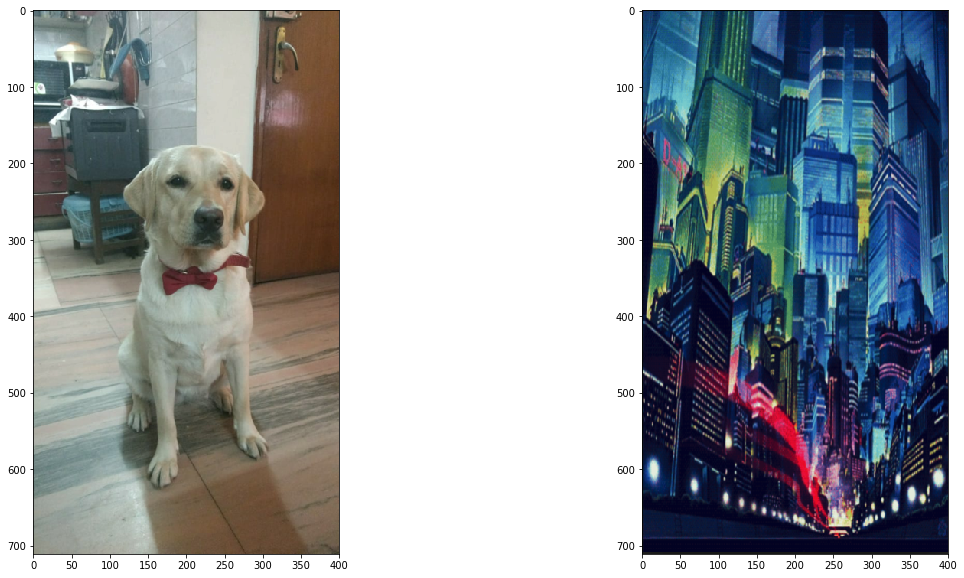

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
def get_features(image, model, layers = None):
  """ Runs image through given model, and returns features for a set of 
      layers provided as a dictionary. Default layers are for VGG19
  """
  
  if layers is None:
    layers = {'0':'conv1_1', '5':'conv2_1','10':'conv3_1','19':'conv4_1','21':'conv4_2','28':'conv5_1'}
    
  features = {}
  x = image
  
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
      
  return features
    

In [0]:
def gram_matrix(tensor):
  """ Calculate the Gram Matrix of a given tensor
  """
  
  _, d, h, w = tensor.size()
  
  tensor = tensor.view(d,h*w)
  
  gmatrix = torch.mm(tensor, tensor.t())
  
  return gmatrix

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  5586047.0


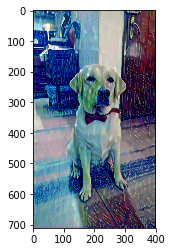

Total loss:  1718718.0


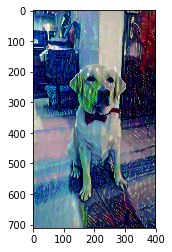

Total loss:  847887.875


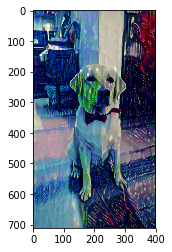

Total loss:  497545.5625


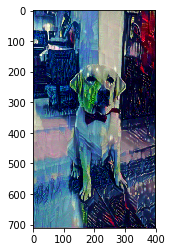

Total loss:  325406.0


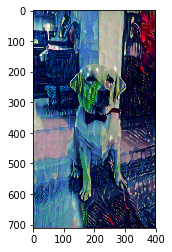

Total loss:  231956.453125


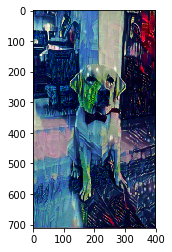

Total loss:  177083.96875


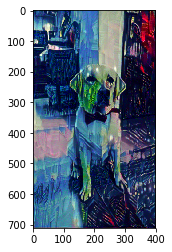

Total loss:  141958.671875


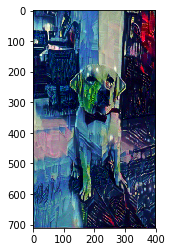

Total loss:  118046.90625


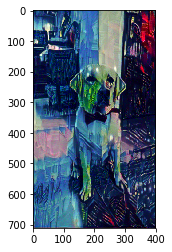

Total loss:  101478.640625


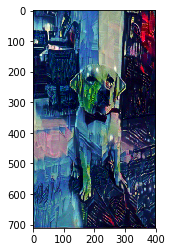

Total loss:  88712.59375


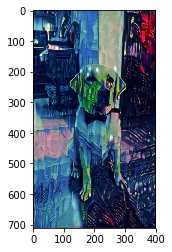

Total loss:  79272.953125


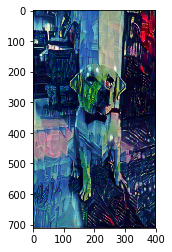

In [26]:
show_every = 400

optimizer = optim.Adam([target], lr=0.003)
steps = 5000  # no of iterations

for ii in range(1, steps+1):
    
    
    target_features = get_features(target, vgg)
    
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    
    style_loss = 0
    
    for layer in style_weights:
        
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss / (d * h * w)
        
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

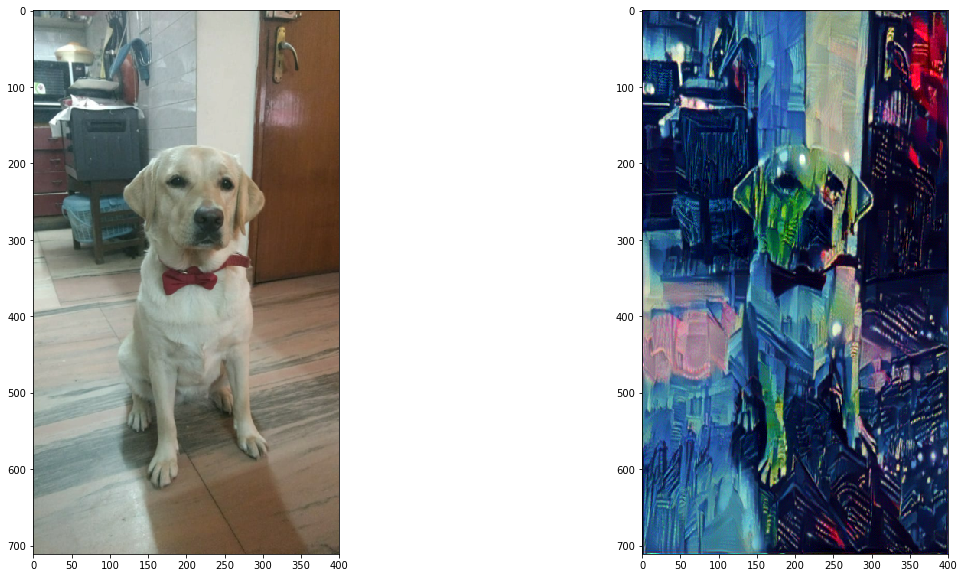

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))